<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-датасетов-и-общий-анализ-представленных-данных" data-toc-modified-id="Загрузка-датасетов-и-общий-анализ-представленных-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка датасетов и общий анализ представленных данных</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Создание-целевого-признака" data-toc-modified-id="Создание-целевого-признака-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Создание целевого признака</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Объединение-датасетов-в-одну-таблицу" data-toc-modified-id="Объединение-датасетов-в-одну-таблицу-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Объединение датасетов в одну таблицу</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Предобработка данных</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Формирование-итогового-датасета." data-toc-modified-id="Формирование-итогового-датасета.-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Формирование итогового датасета.</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#CatBoostClassifier" data-toc-modified-id="CatBoostClassifier-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>CatBoostClassifier</a></span><ul class="toc-item"><li><span><a href="#Корретировка-модели-на-основе-важности-признаков" data-toc-modified-id="Корретировка-модели-на-основе-важности-признаков-6.1.1"><span class="toc-item-num">6.1.1&nbsp;&nbsp;</span>Корретировка модели на основе важности признаков</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-6.1.2"><span class="toc-item-num">6.1.2&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#RandomForestClassifie" data-toc-modified-id="RandomForestClassifie-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>RandomForestClassifie</a></span><ul class="toc-item"><li><span><a href="#Корретировка-модели-на-основе-важности-признаков" data-toc-modified-id="Корретировка-модели-на-основе-важности-признаков-6.2.1"><span class="toc-item-num">6.2.1&nbsp;&nbsp;</span>Корретировка модели на основе важности признаков</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-6.2.2"><span class="toc-item-num">6.2.2&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>LogisticRegression</a></span><ul class="toc-item"><li><span><a href="#Корретировка-модели-на-основе-коэффицентов-важности-признаков" data-toc-modified-id="Корретировка-модели-на-основе-коэффицентов-важности-признаков-6.3.1"><span class="toc-item-num">6.3.1&nbsp;&nbsp;</span>Корретировка модели на основе коэффицентов важности признаков</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-6.3.2"><span class="toc-item-num">6.3.2&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Проверка-модели-на-адекватность-Dummy-классификатором" data-toc-modified-id="Проверка-модели-на-адекватность-Dummy-классификатором-6.4"><span class="toc-item-num">6.4&nbsp;&nbsp;</span>Проверка модели на адекватность Dummy классификатором</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-6.4.1"><span class="toc-item-num">6.4.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

# Цель проекта
Целью данного проекта является прогнозирование оттока клиентов оператора связи.
Прогноз по каждому клиенту будет формировать модель машинного обучения в виде бинарной классификации "1" - клиент уйдет, "0" - клиент не уйдет.
Качество прогнозирования будет определятся метриками ROC AUC И Accuracy.

##  Загрузка датасетов и общий анализ представленных данных

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import auc, roc_curve, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier, Pool
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.dummy import DummyClassifier

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
# df_contr = pd.read_csv('/datasets/final_provider/contract.csv')
# df_pers = pd.read_csv('/datasets/final_provider/personal.csv')
# df_inter = pd.read_csv('/datasets/final_provider/internet.csv')
# df_phone = pd.read_csv('/datasets/final_provider/phone.csv')


df_contr = pd.read_csv('D:\\Documents\\ds\\final\\dataset\\final_provider\\contract.csv')
df_pers = pd.read_csv('D:\\Documents\\ds\\final\\dataset\\final_provider\\personal.csv')
df_inter = pd.read_csv('D:\\Documents\\ds\\final\\dataset\\final_provider\\internet.csv')
df_phone = pd.read_csv('D:\\Documents\\ds\\final\\dataset\\final_provider\\phone.csv')


df_all = [df_contr, df_pers, df_inter, df_phone]
for i in df_all:
    display(i.head())
    i.info()
    print()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB



,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB



,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB



,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB



In [3]:
# Количество уникальных данных в категориальных признаках
for i in [df_contr, df_pers, df_inter, df_phone]:
    for k in list(i):
        if k not in ['customerID', 'BeginDate', 'EndDate', 'MonthlyCharges', 'TotalCharges']:
            print(i[k].value_counts())
            print()

Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64

Yes    4171
No     2872
Name: PaperlessBilling, dtype: int64

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

Male      3555
Female    3488
Name: gender, dtype: int64

0    5901
1    1142
Name: SeniorCitizen, dtype: int64

No     3641
Yes    3402
Name: Partner, dtype: int64

No     4933
Yes    2110
Name: Dependents, dtype: int64

Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64

No     3498
Yes    2019
Name: OnlineSecurity, dtype: int64

No     3088
Yes    2429
Name: OnlineBackup, dtype: int64

No     3095
Yes    2422
Name: DeviceProtection, dtype: int64

No     3473
Yes    2044
Name: TechSupport, dtype: int64

No     2810
Yes    2707
Name: StreamingTV, dtype: int64

No     2785
Yes    2732
Name: StreamingMovies, dtype: int64

No     3390
Yes   

### Вывод
Предоставлено три датасета: датасет с информацией по договорам, датасет с личной информацией пользователей, датасет с данныыми по предоставленным услугами интернета, датасет с данныыми по предоставленным услугам телефонии.  
В датасетах нет пропусков.  
Тип данных столбцов 'BeginDate', 'EndDate', 'TotalCharges' не соответствуют типу содержимого.  
Столбец с индефикатором пользователя 'customerID' пристутствует во всех датасетах.

## Создание целевого признака

In [4]:
df_contr['target'] = df_contr.EndDate.apply(lambda x: 1 if x!='No' else 0)
print('Распределение значений целевого признака:', df_contr['target'].value_counts(), sep='\n')

Распределение значений целевого признака:
0    5174
1    1869
Name: target, dtype: int64


### Вывод
Наличие даты расторжения договора в столбце 'EndDate' означает, что клиент ушел.  
Исходя из этого создан новый столбец с целевым признаком 'target'.  
Целевой признак имеет дисбаланс классов

## Объединение датасетов в одну таблицу

In [5]:
df = df_contr.merge(df_pers, how='left').merge(
             df_inter, how='left').merge(df_phone, how='left')

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   target            7043 non-null   int64  
 9   gender            7043 non-null   object 
 10  SeniorCitizen     7043 non-null   int64  
 11  Partner           7043 non-null   object 
 12  Dependents        7043 non-null   object 
 13  InternetService   5517 non-null   object 
 14  OnlineSecurity    5517 non-null   object 
 15  OnlineBackup      5517 non-null   object 
 16  DeviceProtection  5517 non-null   object 


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target,gender,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,Female,...,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,0,Male,...,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1,Male,...,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,Male,...,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1,Female,...,No,No,Fiber optic,No,No,No,No,No,No,No


In [6]:
df.fillna("unknown", inplace=True)
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target,gender,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,Female,...,Yes,No,DSL,No,Yes,No,No,No,No,unknown
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,0,Male,...,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1,Male,...,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,Male,...,No,No,DSL,Yes,No,Yes,Yes,No,No,unknown
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1,Female,...,No,No,Fiber optic,No,No,No,No,No,No,No


### Вывод
После объединения появились пропуски в данных по потребению услуг интернета и телефонии.  
Пропуски были заполнены значением 'unknown'. 

## Предобработка данных

In [7]:
# Преобразование типа данных столбца 'TotalCharges' в числовой
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
print('Количество строк с пропущенными данными в столбце "TotalCharges" -',
       df.query('TotalCharges.isna()')['customerID'].count()
      )

Количество строк с пропущенными данными в столбце "TotalCharges" - 11


In [8]:
# Удаление строк спропусками в столбце 'TotalCharges'
df.dropna(subset=['TotalCharges'], inplace=True)
print('Количество строк с пропущенными данными в столбце "TotalCharges" -',
       df.query('TotalCharges.isna()')['customerID'].count()
      )

Количество строк с пропущенными данными в столбце "TotalCharges" - 0


In [9]:
# Функция построение гистограммы числового признака
def hist(i):
    plt.figure(figsize=(20, 7))
    sns.histplot(data=df[i], bins=76)
    # plt.title('Всего потрачено денег на услуги')
    plt.xlabel(i)
    plt.ylabel('Количество пользователей')
    plt.show

                                                   Ежемесячные траты на услуги


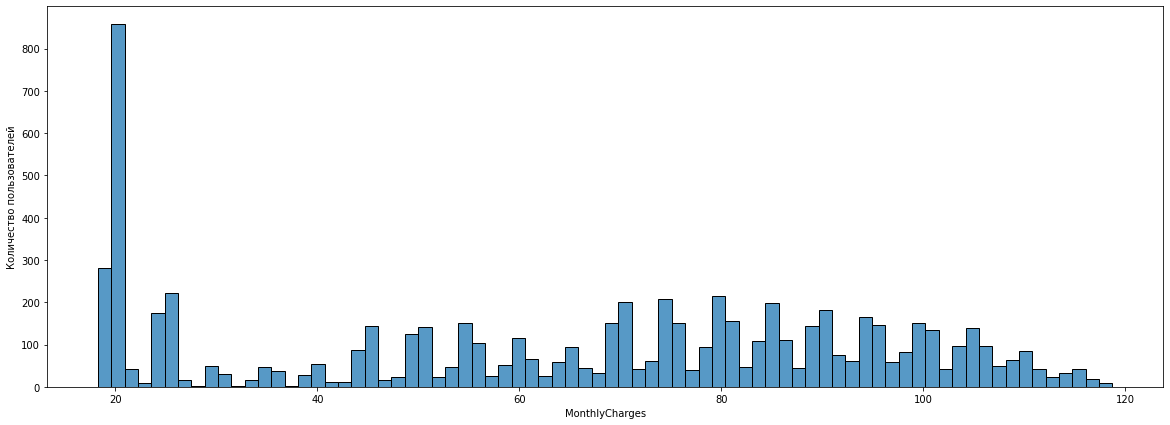

In [10]:
# Построение гистограммы числового признака 'MonthlyCharges'
print(' '*50, 'Ежемесячные траты на услуги')
hist('MonthlyCharges')

                                                   Ежегодные траты на услуги


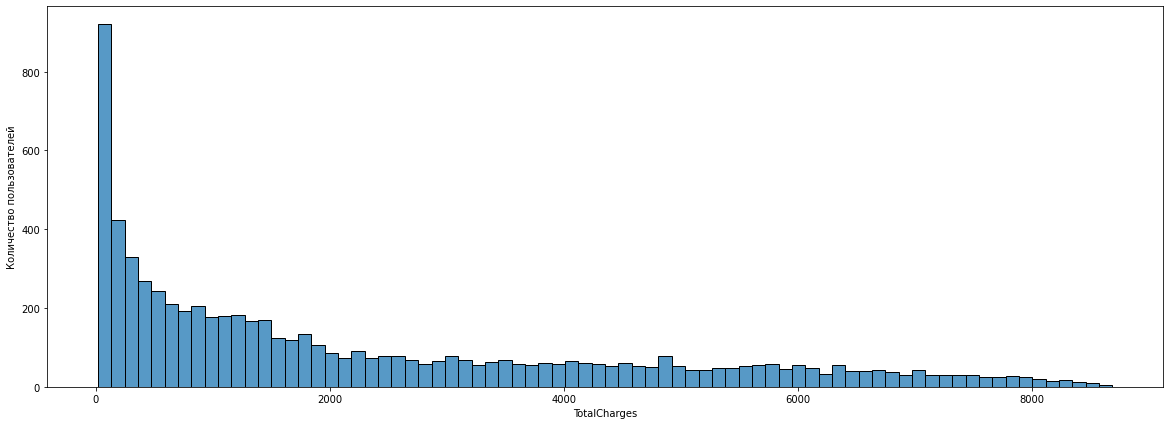

In [11]:
# Построение гистограммы числового признака 'TotalCharges'
print(' '*50,'Ежегодные траты на услуги')
hist('TotalCharges')

In [12]:
# Создание нового признака - количество месяцев с момента заключения контракта
df['BeginDate'] = pd.to_datetime(df['BeginDate'])
r = datetime(year=2020, month=2, day=1)
df['months'] = ((r - df['BeginDate'])/np.timedelta64(1, 'M'))
df['months'] = df['months'].astype(int)
df.head()         

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target,gender,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,months
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,Female,...,No,DSL,No,Yes,No,No,No,No,unknown,1
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,0,Male,...,No,DSL,Yes,No,Yes,No,No,No,No,34
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1,Male,...,No,DSL,Yes,Yes,No,No,No,No,No,4
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,Male,...,No,DSL,Yes,No,Yes,Yes,No,No,unknown,45
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1,Female,...,No,Fiber optic,No,No,No,No,No,No,No,5


                                         Количество месяцев от заключения контракта до 01.02.2022


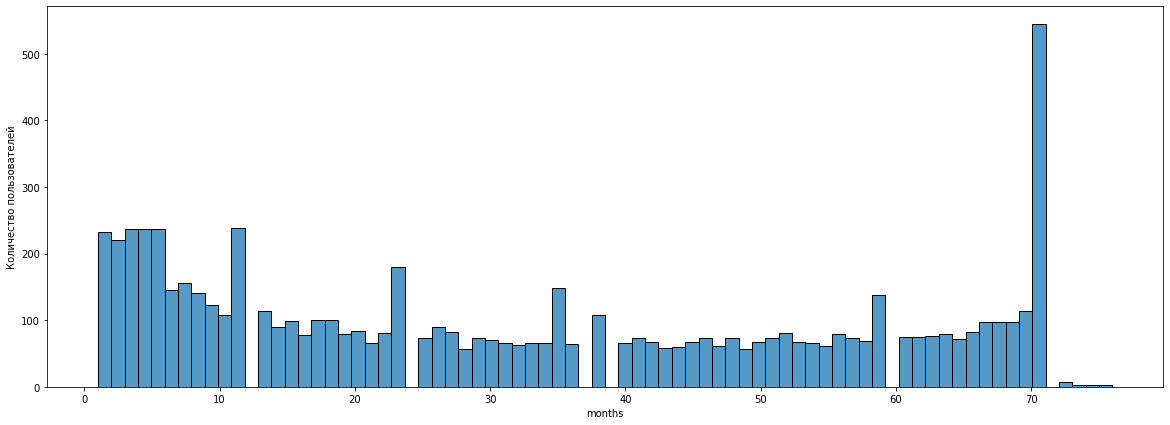

In [13]:
print(' '*40,'Количество месяцев от заключения контракта до 01.02.2022')
hist('months')

In [14]:
# статистические данные числовых признаков
df.loc[:, ['MonthlyCharges', 'TotalCharges', 'months']].describe().round(2)

,MonthlyCharges,TotalCharges,months
count,7032.00,7032.00,7032.00
mean,64.80,2283.30,32.97
std,30.09,2266.77,24.11
min,18.25,18.80,1.00
25%,35.59,401.45,10.00
50%,70.35,1397.48,29.00
75%,89.86,3794.74,56.00
max,118.75,8684.80,76.00


In [15]:
# корреляция Пирсона между числовыми признаками
df.loc[:, ['MonthlyCharges', 'TotalCharges', 'months']].corr()

,MonthlyCharges,TotalCharges,months
MonthlyCharges,1.000000,0.651065,0.259687
TotalCharges,0.651065,1.000000,0.828761
months,0.259687,0.828761,1.000000


### Вывод
Произведена замена типа данных в столбце 'TotalCharges'. Удалены 11 строк с пропусками в столбце 'TotalCharges'.  
Произведена замена типа данных в столбце 'BeginDate'. С помощью этого столбца создан новый признак 'months' - количество месяцев с момента заключения договора до 01.02.2020 г.

## Формирование итогового датасета.

In [16]:
# Удаление ненужных столбцов
df.drop(['customerID', 'BeginDate', 'EndDate'], axis=1, inplace=True)

# Создание списков столбцов с числовыми и категориальеыми признаками
columns = list(df)
columns.remove('target')
columns_num = ['MonthlyCharges', 'TotalCharges', 'months']
columns_cat = list(set(columns)-set(columns_num))

print(' Числовые признаки:', columns_num,'\n'*2,
      'Категориальные признаки:', columns_cat, '\n')
df.info()

 Числовые признаки: ['MonthlyCharges', 'TotalCharges', 'months'] 

 Категориальные признаки: ['DeviceProtection', 'OnlineBackup', 'SeniorCitizen', 'StreamingMovies', 'gender', 'OnlineSecurity', 'Partner', 'PaymentMethod', 'MultipleLines', 'Dependents', 'PaperlessBilling', 'Type', 'InternetService', 'TechSupport', 'StreamingTV'] 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7032 non-null   object 
 1   PaperlessBilling  7032 non-null   object 
 2   PaymentMethod     7032 non-null   object 
 3   MonthlyCharges    7032 non-null   float64
 4   TotalCharges      7032 non-null   float64
 5   target            7032 non-null   int64  
 6   gender            7032 non-null   object 
 7   SeniorCitizen     7032 non-null   int64  
 8   Partner           7032 non-null   object 
 9   Dependents        7032 non-null   objec

### Вывод
Из итоговой таблицы удалены лишние стобцы: 'EndDate' - создает утечку целевого признака, 'customerID' - не влияет на целевой признак, 'BeginDate' - заменен более информативным признаком 'months'.  
В итоговой таблице остуствуют пропуски, числовые признаки в числовом формате.  
Созданы списки чиловых и категориальных признаков.

## Обучение моделей

In [17]:
# Функция разбиения датасета на обучающую и тестовую выборки
def split():
    global target, features, features_train, features_test, target_train, target_test
    target = df['target']
    features = df.drop(['target'], axis=1)
    features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25,
                                                                                  random_state=12345, stratify=df['target'])

In [18]:
# Функция построения ROC-кривой
def grafic(model, features_test, target_test):
    probs = model.predict_proba(features_test)
    preds = probs[:,1]
    fpr, tpr, threshold = roc_curve(target_test, preds)
    roc_auc = auc(fpr, tpr)
    plt.title('ROC-кривая')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
    plt.show()

In [19]:
# Функция построения графика важности факторов
def feature_imp(model):
    feat_importances = pd.Series(model.feature_importances_, index=features.columns)
    plt.figure(figsize=(15, 7))
    feat_importances.nlargest(19).plot(kind='barh')
    plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='both', alpha=0.7)
    plt.title('График важности признаков')
    plt.xlabel('Отностиельная важность')

### CatBoostClassifier

In [20]:
split()

# установка параметров модели
params = {
    'iterations': 1000,
    'learning_rate': 0.1,
    'eval_metric': 'AUC',
    'random_seed': 1234,
    'logging_level': 'Silent',
    'custom_loss': ['AUC', 'Accuracy'],
    'random_seed': 12345,
    'thread_count': 16
     }

train_pool = Pool(features_train, target_train, cat_features=columns_cat) # данные для обучения
validate_pool = Pool(features_test, target_test, cat_features=columns_cat)# данные для тестирования

# обучение модели
model_cat = CatBoostClassifier(**params)
model_cat.fit(train_pool, eval_set=validate_pool, plot=True) 

# Предсказание и получение метрик на тестовой выборке
accur_ct =  accuracy_score(target_test, model_cat.predict(features_test))
roc_auc_ct = roc_auc_score(target_test, model_cat.predict_proba(features_test)[:, 1])

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Метрики полученные при использовании модели  CatBoostClassifier
ROC AUC: 0.942
Accuracy: 0.909


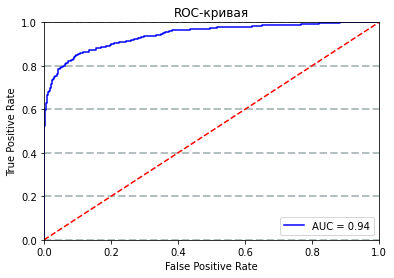

In [21]:
# Вывод метрик и графика AUC ROC
print(f'Метрики полученные при использовании модели  CatBoostClassifier' '\n'
      f'ROC AUC:{roc_auc_ct: .3}' '\n'
      f'Accuracy:{accur_ct: .3}')

grafic(model_cat, features_test, target_test)

####  Корретировка модели на основе важности признаков

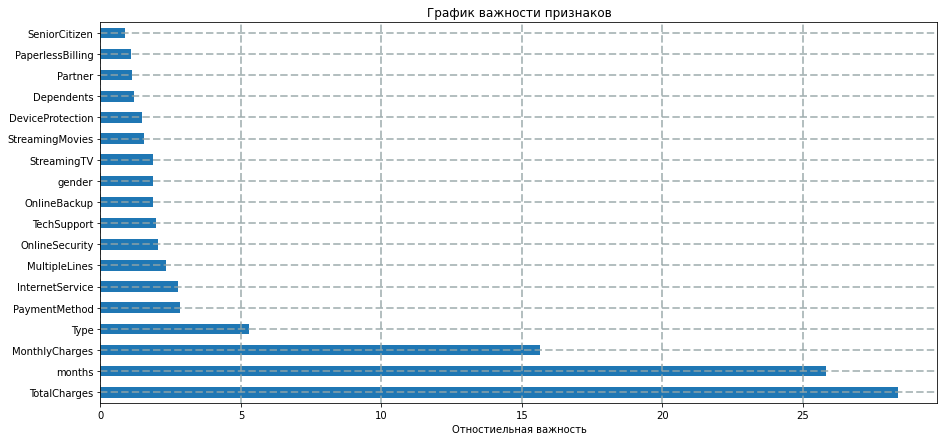

In [22]:
# График важности факторов для модели CatBoostClassifier
feature_imp(model_cat)

In [23]:
# Удаление слабозначимых признаков
split()
s = [features_train, features_test]
features_train = features_train.loc[:, ['Type', 'MonthlyCharges', 'months', 'TotalCharges']]
features_test = features_test.loc[:, ['Type', 'MonthlyCharges', 'months', 'TotalCharges']]

# features_train = features_train.loc[:, ['MultipleLines', 'PaymentMethod', 'InternetService', 'Type',
#                                     'MonthlyCharges', 'months', 'TotalCharges']]
# features_test = features_test.loc[:, ['MultipleLines', 'PaymentMethod', 'InternetService', 'Type',
#                                     'MonthlyCharges', 'months', 'TotalCharges']]

In [24]:
# установка параметров модели
params = {
    'iterations': 1000,
    'learning_rate': 0.1,
    'eval_metric': 'AUC',
    'random_seed': 1234,
    'logging_level': 'Silent',
    'custom_loss': ['AUC', 'Accuracy'],
    'random_seed': 12345,
    'thread_count': 16
     }

columns_cat1 = ['Type']
# columns_cat1 = ['MultipleLines', 'PaymentMethod', 'InternetService', 'Type']
train_pool = Pool(features_train, target_train, cat_features=columns_cat1) # данные для обучения
validate_pool = Pool(features_test, target_test, cat_features=columns_cat1) # данные для тестирования

# обучение модели
model_cat = CatBoostClassifier(**params)
model_cat.fit(train_pool, eval_set=validate_pool, plot=True) 

# Предсказание и получение метрик на тестовой выборке
accur_ct =  accuracy_score(target_test, model_cat.predict(features_test))
roc_auc_ct = roc_auc_score(target_test, model_cat.predict_proba(features_test)[:, 1])

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Метрики полученные при использовании модели  CatBoostClassifier
ROC AUC: 0.95
Accuracy: 0.919


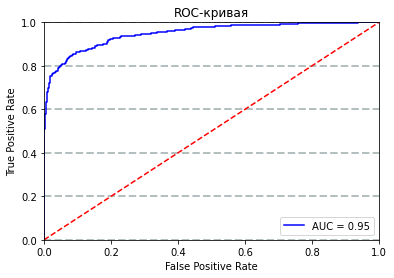

In [25]:
# Вывод метрик и графика AUC ROC
print(f'Метрики полученные при использовании модели  CatBoostClassifier' '\n'
      f'ROC AUC:{roc_auc_ct: .3}' '\n'
      f'Accuracy:{accur_ct: .3}')

grafic(model_cat, features_test, target_test)

#### Вывод
Изменение набора признаков на основе важности позволила увеличить метрику ROC AUC  0.942 до 0.95

### RandomForestClassifie

In [26]:
split()

# Предварительная обработка данных перед обучением модели

# Кодирование методом LabelEncoder категориальных признаков
labelencoder = LabelEncoder()
for i in columns_cat:
    features_train[i] = labelencoder.fit_transform(features_train[i])
    features_test[i] = labelencoder.transform(features_test[i])

features_train.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,months
2165,1,0,3,20.20,273.25,0,0,0,0,2,2,2,2,2,2,2,0,13
3814,2,1,1,88.70,6301.70,1,0,1,0,0,1,1,1,1,1,1,1,71
2514,0,1,2,89.70,2187.55,0,1,0,0,1,0,1,0,0,0,1,1,27
3837,1,1,2,105.65,443.90,0,0,0,0,1,0,1,1,1,1,1,0,6
2573,0,1,3,54.75,54.75,0,0,0,0,0,0,0,0,0,0,1,0,2


In [27]:
# Сетка гиперпараметров
parametrs = { 'n_estimators': range(10, 31, 10),
              'max_depth': range(1, 11, 2),
              'min_samples_leaf': range(1, 8),
              'min_samples_split': range(2, 10, 2),
              'class_weight': ['balanced'] }

# Обучение модели с кросс-валидацией
model_rf = GridSearchCV(RandomForestClassifier(), parametrs, cv=5, scoring='roc_auc', n_jobs=-1)
model_rf.fit(features_train, target_train)
pred_rf = model_rf.predict(features_test)

# Предсказание и получение метрик на тестовой выборке
accur_rf = accuracy_score(target_test, pred_rf)
roc_auc_rf = roc_auc_score(target_test, model_rf.predict_proba(features_test)[:, 1])

Метрики полученные при использовании модели RandomForestClassifier:
ROC AUC: 0.886
Accuracy: 0.813


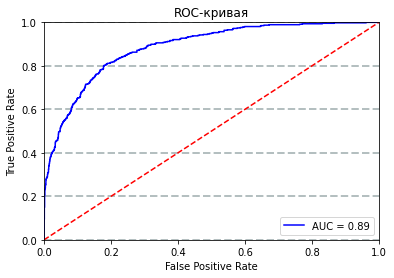

In [28]:
# Вывод метрик и графика AUC ROC
print(f'Метрики полученные при использовании модели RandomForestClassifier:' '\n'
      f'ROC AUC:{roc_auc_rf: .3}' '\n'
      f'Accuracy:{accur_rf: .3}')

grafic(model_rf, features_test, target_test)

####  Корретировка модели на основе важности признаков

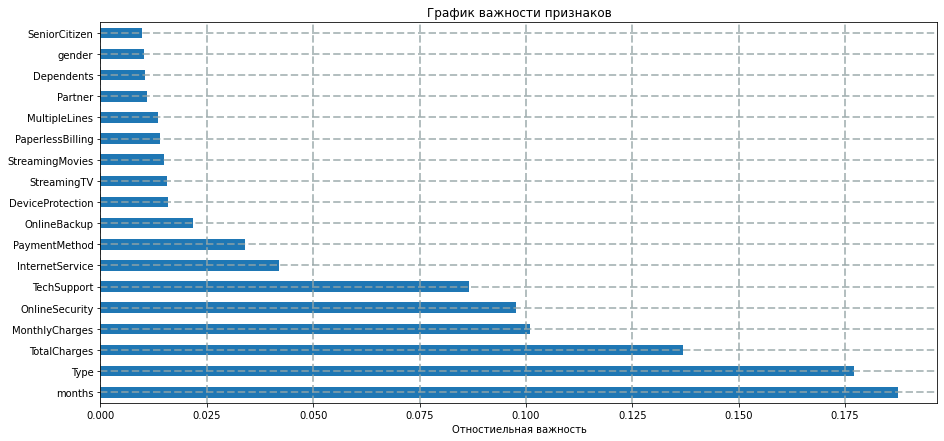

In [29]:
# График важности факторов для модели CatBoostClassifier
feature_imp(model_rf.best_estimator_)

In [30]:
split()

# Удаление слабозначимых признаков
features_test = features_test.loc[:, ['MonthlyCharges', 'TotalCharges', 'Type', 'months']]
features_train = features_train.loc[:, ['MonthlyCharges', 'TotalCharges', 'Type', 'months']]

# Кодирование методом LabelEncoder категориальных признаков
columns_cat2 = ['Type']
labelencoder = LabelEncoder()
for i in columns_cat2:
    features_train[i] = labelencoder.fit_transform(features_train[i])
    features_test[i] = labelencoder.transform(features_test[i])

In [31]:
# Сетка гиперпараметров
parametrs = { 'n_estimators': range(10, 31, 10),
              'max_depth': range(1, 11, 2),
              'min_samples_leaf': range(1, 8),
              'min_samples_split': range(2, 10, 2),
              'class_weight': ['balanced'] }

# Обучение модели с кросс-валидацией
model_rf = GridSearchCV(RandomForestClassifier(), parametrs, cv=5, scoring='roc_auc', n_jobs=-1)
model_rf.fit(features_train, target_train)
pred_rf = model_rf.predict(features_test)

# Предсказание и получение метрик на тестовой выборке
accur_rf = accuracy_score(target_test, pred_rf)
roc_auc_rf = roc_auc_score(target_test, model_rf.predict_proba(features_test)[:, 1])

Метрики полученные при использовании модели RandomForestClassifier:
ROC AUC: 0.903
Accuracy: 0.827


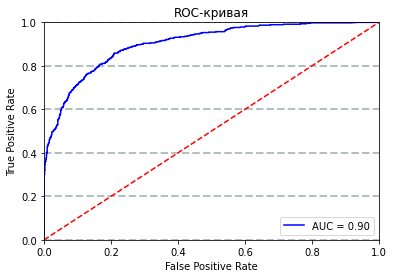

In [32]:
# Вывод метрик и графика AUC ROC
print(f'Метрики полученные при использовании модели RandomForestClassifier:' '\n'
      f'ROC AUC:{roc_auc_rf: .3}' '\n'
      f'Accuracy:{accur_rf: .3}')

grafic(model_rf, features_test, target_test)

#### Вывод
Изменение набора признаков на основе важности позволила увеличить метрику ROC AUC  0.886 до 0.901

### LogisticRegression

In [33]:
split()

# Предварительная обработка данных перед обучением модели

# Кодирование методом One-Hot Encoding категориальных признаков
features_train = pd.get_dummies(features_train, columns=columns_cat, drop_first=True)
features_test = pd.get_dummies(features_test, columns=columns_cat, drop_first=True)

# Массштабирование числовых признаков
scaler = MinMaxScaler()
for i in columns_num:
    features_train[i] = scaler.fit_transform(features_train.loc[:, [i]])
    features_test[i] = scaler.transform(features_test.loc[:, [i]])
    
features_train.head()

,MonthlyCharges,TotalCharges,months,DeviceProtection_Yes,DeviceProtection_unknown,OnlineBackup_Yes,OnlineBackup_unknown,SeniorCitizen_1,StreamingMovies_Yes,StreamingMovies_unknown,...,Dependents_Yes,PaperlessBilling_Yes,Type_One year,Type_Two year,InternetService_Fiber optic,InternetService_unknown,TechSupport_Yes,TechSupport_unknown,StreamingTV_Yes,StreamingTV_unknown
2165,0.019432,0.029412,0.160000,0,1,0,1,0,0,1,...,0,0,1,0,0,1,0,1,0,1
3814,0.702043,0.726238,0.933333,1,0,1,0,0,1,0,...,0,1,0,1,0,0,1,0,1,0
2514,0.712008,0.250685,0.346667,0,0,1,0,1,1,0,...,0,1,0,0,1,0,0,0,0,0
3837,0.870952,0.049137,0.066667,1,0,1,0,0,1,0,...,0,1,1,0,1,0,1,0,1,0
2573,0.363727,0.004155,0.013333,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0


In [34]:
# Сетка гиперпараметров
parametrs = {'C': [0.001,0.01,0.1,1,10,100,1000],
                 'solver': ['lbfgs', 'liblinear'], 'class_weight': ['balanced'] }

# Обучение модели с кросс-валидацией
model_log = GridSearchCV(LogisticRegression(), parametrs, cv=5, scoring='roc_auc', n_jobs=-1)
model_log.fit(features_train, target_train)

# Предсказание и получение метрик на тестовой выборке
pred_log = model_log.predict(features_test)
acc_log = accuracy_score(target_test, pred_log)
roc_auc_log = roc_auc_score(target_test, model_log.predict_proba(features_test)[:, 1])

Метрики полученные при использовании модели LogisticRegression:
 ROC AUC: 0.847
Accuracy: 0.743


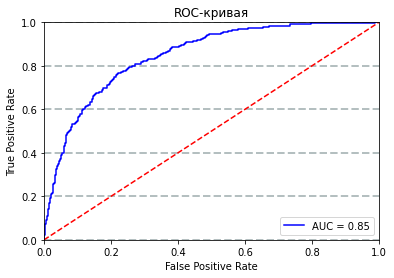

In [35]:
# Вывод метрик и графика ROC AUC
print(f'Метрики полученные при использовании модели LogisticRegression:' '\n'
      f' ROC AUC:{roc_auc_log: .3}' '\n'
      f'Accuracy:{acc_log: .3}')

grafic(model_log, features_test, target_test)

####  Корретировка модели на основе коэффицентов важности признаков

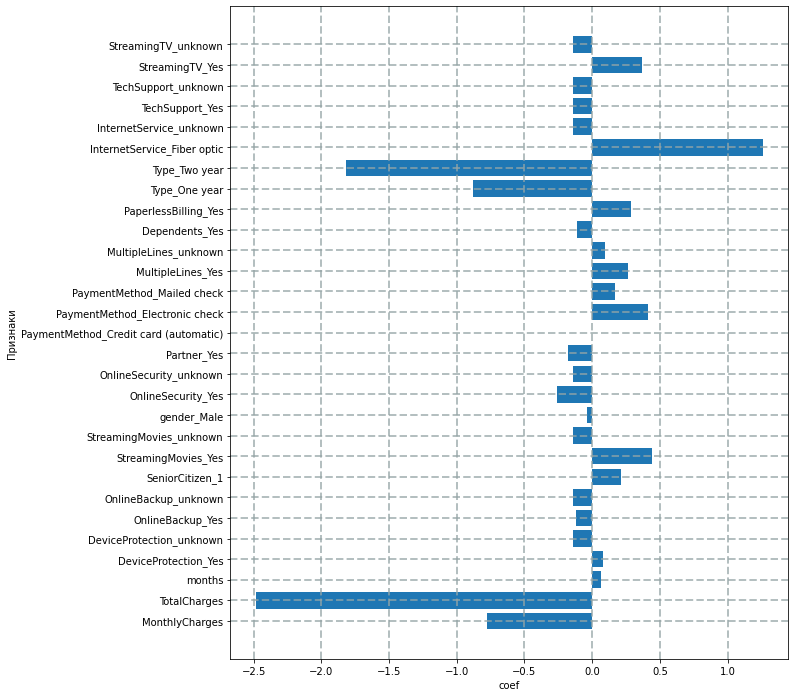

In [36]:
# Обучение модели, и вывод коэфициентов по каждому признаку в виде графика

plt.figure(figsize=(10, 12))
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='both', alpha=0.7)
ax1 = plt.subplot()
ax1.set_yticks(range(29))
ax1.set_yticklabels(list(features_train))
plt.ylabel('Признаки')
plt.xlabel('coef')

# Вычисление коэфициентов 
importance = model_log.best_estimator_.coef_[0]

plt.barh([x for x in range(len(importance))], importance)
plt.show()

In [37]:
# Удаление признаков c низкими коэффицентами
split()

features_test = features_test.loc[:, ['Type', 'PaymentMethod', 'PaperlessBilling', 'StreamingMovies', 'StreamingTV',
              'InternetService','TotalCharges','MonthlyCharges']]
features_train = features_train.loc[:, ['Type', 'PaymentMethod', 'PaperlessBilling', 'StreamingMovies', 'StreamingTV',
              'InternetService','TotalCharges','MonthlyCharges']]    
    
# Кодирование методом One-Hot Encoding категориальных признаков
columns_cat3 =  ['Type', 'PaymentMethod', 'PaperlessBilling', 
                 'StreamingMovies', 'StreamingTV',  'InternetService']
features_train = pd.get_dummies(features_train, columns=columns_cat3, drop_first=True)
features_test = pd.get_dummies(features_test, columns=columns_cat3, drop_first=True)

# Массштабирование числовых признаков
columns_num3 = ['TotalCharges','MonthlyCharges']
scaler = MinMaxScaler()
for i in columns_num3:
    features_train[i] = scaler.fit_transform(features_train.loc[:, [i]])
    features_test[i] = scaler.transform(features_test.loc[:, [i]])

In [38]:
# Сетка гиперпараметров
parametrs = {'C': [0.001,0.01,0.1,1,10,100,1000],
                 'solver': ['lbfgs', 'liblinear'], 'class_weight': ['balanced'] }

# Обучение модели с кросс-валидацией
model_log = GridSearchCV(LogisticRegression(), parametrs, cv=5, scoring='roc_auc', n_jobs=-1)
model_log.fit(features_train, target_train)

# Предсказание и получение метрик на тестовой выборке
pred_log = model_log.predict(features_test)
acc_log = accuracy_score(target_test, pred_log)
roc_auc_log = roc_auc_score(target_test, model_log.predict_proba(features_test)[:, 1])

Метрики полученные при использовании модели LogisticRegression:
 ROC AUC: 0.844
Accuracy: 0.741


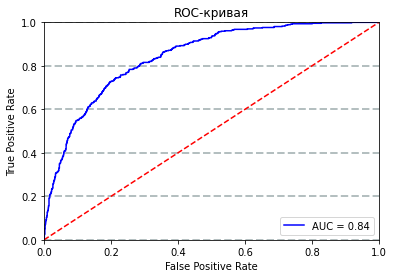

In [39]:
# Вывод метрик и графика ROC AUC
print(f'Метрики полученные при использовании модели LogisticRegression:' '\n'
      f' ROC AUC:{roc_auc_log: .3}' '\n'
      f'Accuracy:{acc_log: .3}')

grafic(model_log, features_test, target_test)

#### Вывод
Корретировка модели на основе коэффицентов важности призназнаков не увеличила метрику ROC AUC

### Проверка модели на адекватность Dummy классификатором

In [40]:
split()
strategies = ['most_frequent', 'prior', 'stratified', 'uniform', 'constant']
roc_auc_scores = []
accuracy_scores = []

for s in strategies:
    if s == 'constant':
        model_dm = DummyClassifier(strategy = s, random_state = 12345, constant = 0)
    else:
        model_dm = DummyClassifier(strategy = s, random_state = 12345)
        model_dm.fit(features_train, target_train)

        pred_d = model_dm.predict(features_test)
        accuracy = accuracy_score(target_test, pred_d)
        accuracy_scores.append(accuracy)

        roc_auc_dm = roc_auc_score(target_test, model_dm.predict_proba(target_test)[:, 1])
        roc_auc_scores.append(roc_auc_dm)

        
print(f'Метрики полученные при использовании Dummy классификатора:' '\n'
      f'ROC AUC:{max(roc_auc_scores): .3}' '\n'
      f'Accuracy:{max(accuracy_scores): .3}')      

Метрики полученные при использовании Dummy классификатора:
ROC AUC: 0.505
Accuracy: 0.734


#### Вывод
Модели, применённые  в проекте прошли проверку на адекватность, так как метрики полученные при использовании Dummy классификатора значительно хуже метрик рабочих моделей.

## Вывод
В данном проекте решалась задача прогнозирование оттока клиентов оператора связи с помощью моделей машинного обучения. Точность предсказаний оттока клиентов описывается метриками ROC AUC и  Accuracy. Величина ROC AUC должна быть не ниже 0.75.  

Были представлены 4 датасета с данными пользователей и информацией по использованным услугам. Предоставленные данные были обработаны: удалены пропуски, преобразованы типы данных столбцов. Все данные были объединены в одну таблицу. На основе одного из признаков ‘EndDate’ был создан столбец с целевым признаком.  
Для получения прогнозов ухода клиентов были использованы 3 модели машинного обучения CatBoostClassifier, RandomForestClassifier, LogisticRegression. Для моделей RandomForestClassifier, LogisticRegression дополнительно проводилась предобработка данных с учетом особенностей работы моделей.
Перед использованием моделей вся данные разбивались на обучающую и тестовую выборки. Обучение моделей проводилось на обучающей выборке. Проверка работы моделей производилось на тестовой выборке.  
По каждой модели были получены метрики ROC AUC  Accuracy показывающие точность предсказаний. Самые высокие показатели метрик у модели CatBoostClassifie: ROC AUC 0.94  Accuracy 0.91, ниже показатели у модели RandomForestClassifier:  ROC AUC 0.88  Accuracy 0.80, самые низкие показатели метрик у модели LogisticRegression: ROC AUC 0.85  Accuracy 0.74. Все модели   прошли проверку на адекватность.  
Анализ важности факторов на использованных моделях показал, что имеются признаки оказывающие значительное влияние на уход клиентов:  'Всего потрачено денег на услуги', 'Ежемесячные траты на услуги', 'Тип оплаты', 'Количество месяцев с момента заключения договора'.

Полученные показатели метрик позволяют утверждать, что проект решает поставленную задачу.